##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple TFX Pipeline for Vertex Pipelines


This notebook-based tutorial will create a simple TFX pipeline and run it using
Google Cloud Vertex Pipelines.  This notebook is based on the TFX pipeline
built in
[Simple TFX Pipeline Tutorial](https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple).

Google Cloud Vertex Pipelines helps you to automate, monitor, and govern
your ML systems by orchestrating your ML workflow in a serverless manner. You
can define your ML pipelines using Python with TFX, and then execute your
pipelines on Google Cloud. See
[Vertex Pipelines introduction](https://cloud.google.com/vertex-ai/docs/pipelines/introduction)
to learn more about Vertex Pipelines.

## Setup
### Install python packages

We will install required Python packages including TFX and KFP to author ML
pipelines and submit jobs to Vertex Pipelines.

In [1]:
# Use the latest version of pip.
!pip install --upgrade pip
!pip install --upgrade "tfx[kfp]<2"

     |████████████████████████████████| 2.1 MB 3.9 MB/s            
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 92.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.1 MB/s eta 0:00:00
  Obtaining dependency information for portpicker<2,>=1.3.1 from https://files.pythonhosted.org/packages/32/2d/440e4d7041fff89f28f483733eb617127aa866135c2dc719e05893f089e1/portpicker-1.6.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.6 MB/s eta 0:00:00
  Obtaining dependency information for apache-beam[gcp]<3,>=2.40 from https://fi

#### Restart the runtime

Restart the runtime to ensure the following cells use the updated versions.

You can restart the runtime with following cell:

In [2]:
# docs_infra: no_execute
import sys
if not 'google.colab' in sys.modules:
  # Automatically restart kernel after installs
  import IPython
  app = IPython.Application.instance()
  app.kernel.do_shutdown(True)

Check the package versions.

In [1]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))
import kfp
print('KFP version: {}'.format(kfp.__version__))

2023-09-17 09:11:10.811242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 09:11:11.022935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-17 09:11:11.022995: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-17 09:11:11.049768: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-17 09:11:11.990591: W tensorflow/stream_executor/platform/de

TensorFlow version: 2.10.1
TFX version: 1.11.0
KFP version: 1.8.22


### Set up variables

We will set up some variables used to customize the pipelines below. Following
information is required:

* GCP Project id. You can find your Project ID in the panel with your lab instructions.
* GCP Region to run pipelines. For more information about the regions that
Vertex Pipelines is available in, see the
[Vertex AI locations guide](https://cloud.google.com/vertex-ai/docs/general/locations#feature-availability).
* Google Cloud Storage Bucket to store pipeline outputs.

**Enter required values in the cell below before running it**.


GCP Project ID  : qwiklabs-gcp-03-689ba761489c (실습 할 때 제공해준 것) 

In [9]:
GOOGLE_CLOUD_PROJECT = 'qwiklabs-gcp-03-689ba761489c'     # <--- ENTER THIS
GOOGLE_CLOUD_REGION = 'us-east1'     
GCS_BUCKET_NAME = GOOGLE_CLOUD_PROJECT + '-gcs'

if not (GOOGLE_CLOUD_PROJECT and GOOGLE_CLOUD_REGION and GCS_BUCKET_NAME):
    from absl import logging
    logging.error('Please set all required parameters.')

Set `gcloud` to use your project.

In [10]:
!gcloud config set project {GOOGLE_CLOUD_PROJECT}

Updated property [core/project].


In [11]:
PIPELINE_NAME = 'penguin-vertex-pipelines'

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(
    GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for users' Python module.
MODULE_ROOT = 'gs://{}/pipeline_module/{}'.format(
    GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for input data.
DATA_ROOT = 'gs://{}/data/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# This is the path where your model will be pushed for serving.
SERVING_MODEL_DIR = 'gs://{}/serving_model/{}'.format(
    GCS_BUCKET_NAME, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))

PIPELINE_ROOT: gs://qwiklabs-gcp-03-689ba761489c-gcs/pipeline_root/penguin-vertex-pipelines


### Prepare example data
The dataset we are using is the
[Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/articles/intro.html).

There are four numeric features in this dataset:

* culmen_length_mm
* culmen_depth_mm
* flipper_length_mm
* body_mass_g

All features were already normalized
to have range [0,1]. We will build a classification model which predicts the
`species` of penguins.

We need to make our own copy of the dataset. Because TFX ExampleGen reads
inputs from a directory, we need to create a directory and copy dataset to it
on GCS.

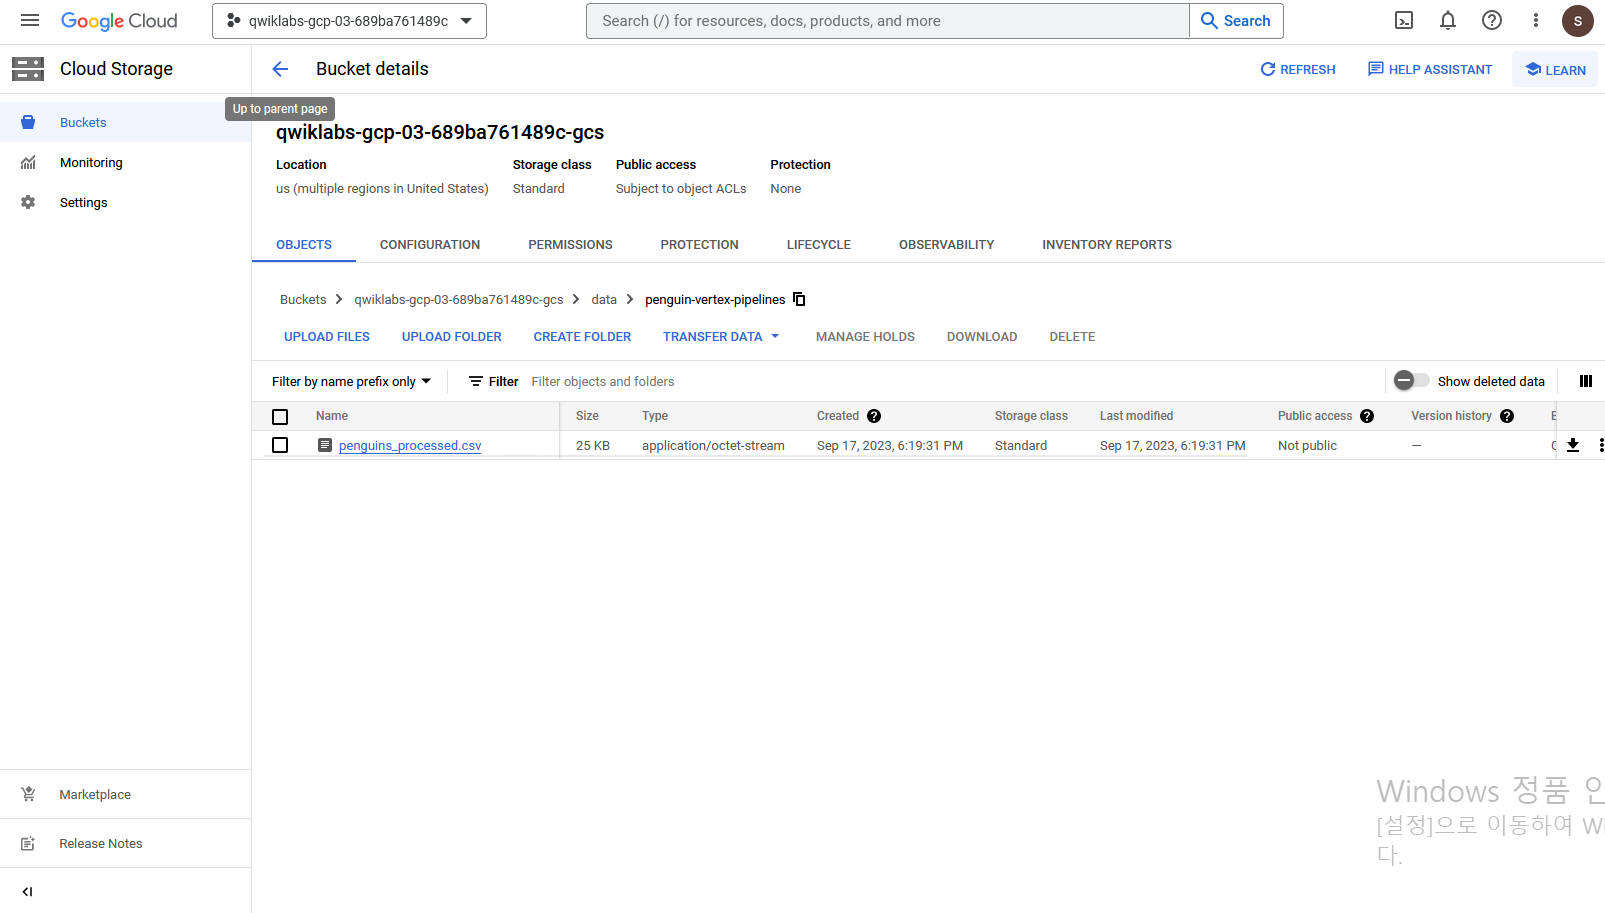

In [12]:
!gsutil cp gs://download.tensorflow.org/data/palmer_penguins/penguins_processed.csv {DATA_ROOT}/

Copying gs://download.tensorflow.org/data/palmer_penguins/penguins_processed.csv [Content-Type=application/octet-stream]...
/ [1 files][ 25.0 KiB/ 25.0 KiB]                                                
Operation completed over 1 objects/25.0 KiB.                                     


Take a quick look at the CSV file.

In [13]:
!gsutil cat {DATA_ROOT}/penguins_processed.csv | head

species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,0.2545454545454545,0.6666666666666666,0.15254237288135594,0.2916666666666667
0,0.26909090909090905,0.5119047619047618,0.23728813559322035,0.3055555555555556
0,0.29818181818181805,0.5833333333333334,0.3898305084745763,0.1527777777777778
0,0.16727272727272732,0.7380952380952381,0.3559322033898305,0.20833333333333334
0,0.26181818181818167,0.892857142857143,0.3050847457627119,0.2638888888888889
0,0.24727272727272717,0.5595238095238096,0.15254237288135594,0.2569444444444444
0,0.25818181818181823,0.773809523809524,0.3898305084745763,0.5486111111111112
0,0.32727272727272727,0.5357142857142859,0.1694915254237288,0.1388888888888889
0,0.23636363636363636,0.9642857142857142,0.3220338983050847,0.3055555555555556


You should be able to see five values. `species` is one of 0, 1 or 2, and all other features should have values between 0 and 1.

## Create a pipeline

TFX pipelines are defined using Python APIs. We will define a pipeline which
consists of three components:

* CsvExampleGen: Reads in data files and convert them to TFX internal format for further processing. There are multiple ExampleGens for various formats. In this tutorial, we will use CsvExampleGen which takes CSV file input.
* Trainer: Trains an ML model. Trainer component requires a model definition code from users. You can use TensorFlow APIs to specify how to train a model and save it in a _savedmodel format.
* Pusher: Copies the trained model outside of the TFX pipeline. Pusher component can be thought of an deployment process of the trained ML model.

Our pipeline will be almost identical to a basic [TFX pipeline](https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple).

The only difference is that we don't need to set `metadata_connection_config`
which is used to locate
[ML Metadata](https://www.tensorflow.org/tfx/guide/mlmd) database. Because
Vertex Pipelines uses a managed metadata service, users don't need to care
of it, and we don't need to specify the parameter.

Before actually define the pipeline, we need to write a model code for the
Trainer component first.

### Write model code.

We will create a simple DNN model for classification using TensorFlow Keras API. This model training code will be saved to a separate file.

In this tutorial we will use __Generic Trainer__ of TFX which support Keras-based models. You need to write a Python file containing run_fn function, which is the entrypoint for the `Trainer` component.

In [14]:
_trainer_module_file = 'penguin_trainer.py'

In [15]:
%%writefile {_trainer_module_file}

# Copied from https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple

from typing import List
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_transform.tf_metadata import schema_utils


from tfx import v1 as tfx
from tfx_bsl.public import tfxio

from tensorflow_metadata.proto.v0 import schema_pb2

_FEATURE_KEYS = [
    'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
]
_LABEL_KEY = 'species'

_TRAIN_BATCH_SIZE = 20
_EVAL_BATCH_SIZE = 10

# Since we're not generating or creating a schema, we will instead create
# a feature spec.  Since there are a fairly small number of features this is
# manageable for this dataset.
_FEATURE_SPEC = {
    **{
        feature: tf.io.FixedLenFeature(shape=[1], dtype=tf.float32)
           for feature in _FEATURE_KEYS
       },
    _LABEL_KEY: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
}


def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _make_keras_model() -> tf.keras.Model:
  """Creates a DNN Keras model for classifying penguin data.

  Returns:
    A Keras Model.
  """
  # The model below is built with Functional API, please refer to
  # https://www.tensorflow.org/guide/keras/overview for all API options.
  inputs = [keras.layers.Input(shape=(1,), name=f) for f in _FEATURE_KEYS]
  d = keras.layers.concatenate(inputs)
  for _ in range(2):
    d = keras.layers.Dense(8, activation='relu')(d)
  outputs = keras.layers.Dense(3)(d)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """

  # This schema is usually either an output of SchemaGen or a manually-curated
  # version provided by pipeline author. A schema can also derived from TFT
  # graph if a Transform component is used. In the case when either is missing,
  # `schema_from_feature_spec` could be used to generate schema from very simple
  # feature_spec, but the schema returned would be very primitive.
  schema = schema_utils.schema_from_feature_spec(_FEATURE_SPEC)

  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      schema,
      batch_size=_TRAIN_BATCH_SIZE)
  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      schema,
      batch_size=_EVAL_BATCH_SIZE)

  model = _make_keras_model()
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps)

  # The result of the training should be saved in `fn_args.serving_model_dir`
  # directory.
  model.save(fn_args.serving_model_dir, save_format='tf')

Writing penguin_trainer.py


Copy the module file to GCS which can be accessed from the pipeline components.
Because model training happens on GCP, we need to upload this model definition. 

Otherwise, you might want to build a container image including the module file
and use the image to run the pipeline.

In [16]:
!gsutil cp {_trainer_module_file} {MODULE_ROOT}/

Copying file://penguin_trainer.py [Content-Type=text/x-python]...
/ [1 files][  3.8 KiB/  3.8 KiB]                                                
Operation completed over 1 objects/3.8 KiB.                                      


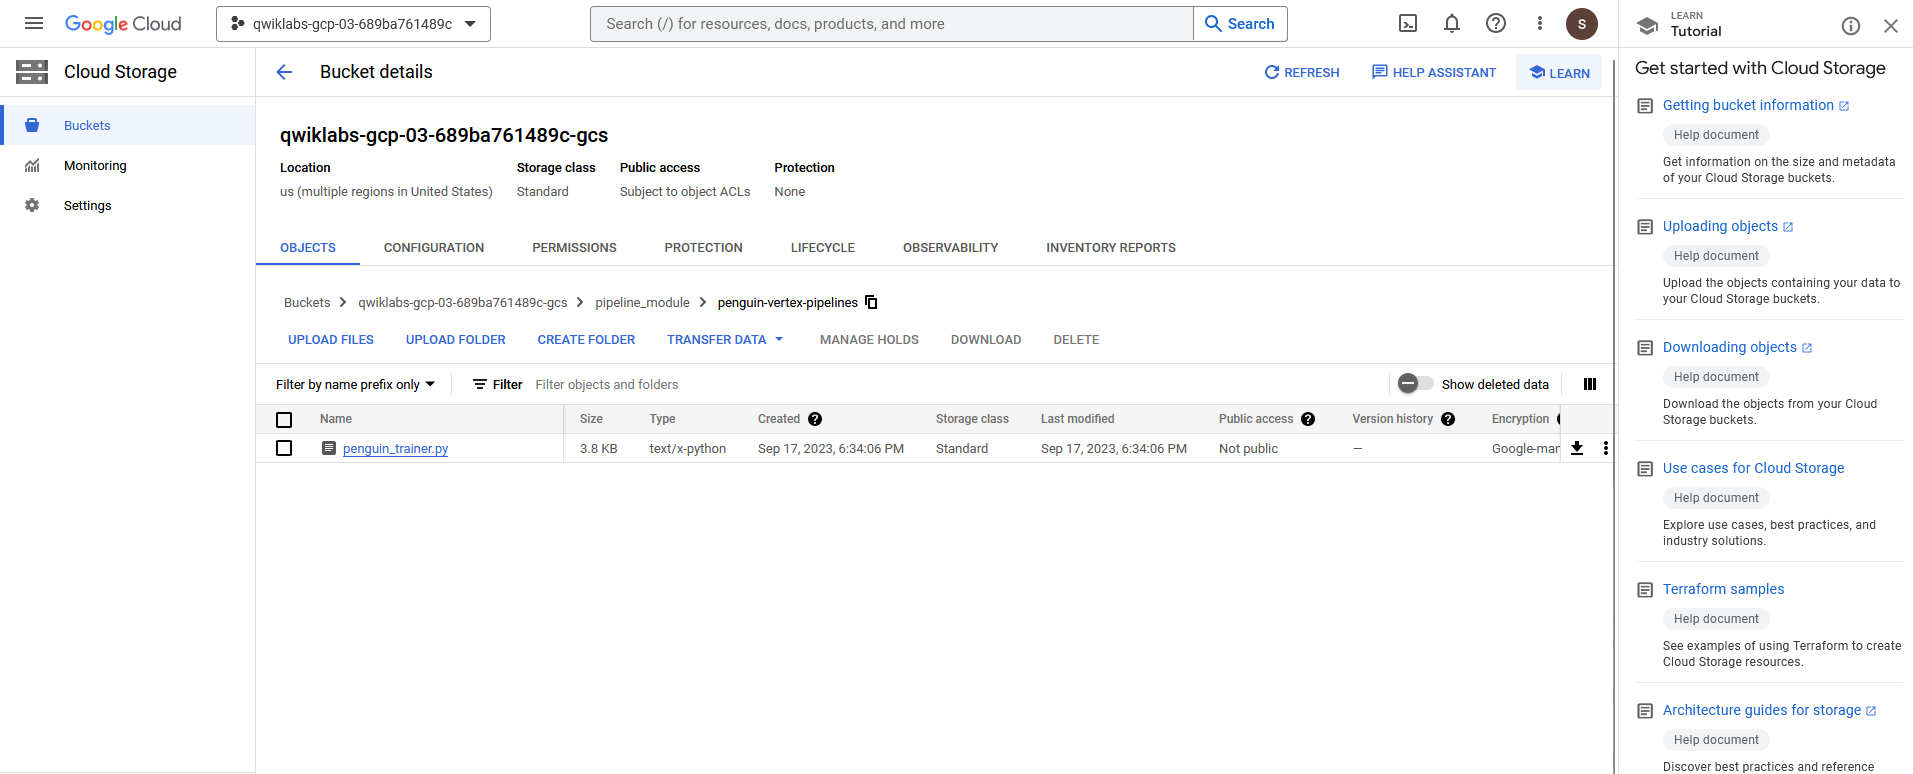

### Write a pipeline definition

We will define a function to create a TFX pipeline.

In [17]:
# Copied from https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple and
# slightly modified because we don't need `metadata_path` argument.

def _create_pipeline(pipeline_name: str, pipeline_root: str, data_root: str,
                     module_file: str, serving_model_dir: str,
                     ) -> tfx.dsl.Pipeline:
  """Creates a three component penguin pipeline with TFX."""
  # Brings data into the pipeline.
  example_gen = tfx.components.CsvExampleGen(input_base=data_root)

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(num_steps=100),
      eval_args=tfx.proto.EvalArgs(num_steps=5))

  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      trainer,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      components=components)

## Run the pipeline on Vertex Pipelines.

TFX provides multiple orchestrators to run your pipeline. In this tutorial we
will use the Vertex Pipelines together with the Kubeflow V2 dag runner.

We need to define a runner to actually run the pipeline. You will compile
your pipeline into our pipeline definition format using TFX APIs.

In [18]:
import os

PIPELINE_DEFINITION_FILE = PIPELINE_NAME + '_pipeline.json'

runner = tfx.orchestration.experimental.KubeflowV2DagRunner(
    config=tfx.orchestration.experimental.KubeflowV2DagRunnerConfig(),
    output_filename=PIPELINE_DEFINITION_FILE)
# Following function will write the pipeline definition to PIPELINE_DEFINITION_FILE.
_ = runner.run(
    _create_pipeline(
        pipeline_name=PIPELINE_NAME,
        pipeline_root=PIPELINE_ROOT,
        data_root=DATA_ROOT,
        module_file=os.path.join(MODULE_ROOT, _trainer_module_file),
        serving_model_dir=SERVING_MODEL_DIR))

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying penguin_trainer.py -> build/lib
installing to /tmp/tmpghass0qj
running install
running install_lib
copying build/lib/penguin_trainer.py -> /tmp/tmpghass0qj
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmp/tmpghass0qj/tfx_user_code_Trainer-0.0+afa8d5dfaf2942b08385545b5e095850331200a5d7a669b1791b3e7efcc5fdd9-py3.7.egg-info
running install_scripts
creating /tmp/tmpghass0qj/tfx_user_code_Trainer-0.0+afa8d5dfaf2942b08385545b5e0

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


The generated definition file can be submitted using kfp client.

In [19]:
# docs_infra: no_execute
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs

aiplatform.init(project=GOOGLE_CLOUD_PROJECT, location=GOOGLE_CLOUD_REGION)

job = pipeline_jobs.PipelineJob(template_path=PIPELINE_DEFINITION_FILE,
                                display_name=PIPELINE_NAME)
job.run(sync=False)

Visit __Vertex AI > Pipelines__ in your Google Cloud Console page to see the progress.

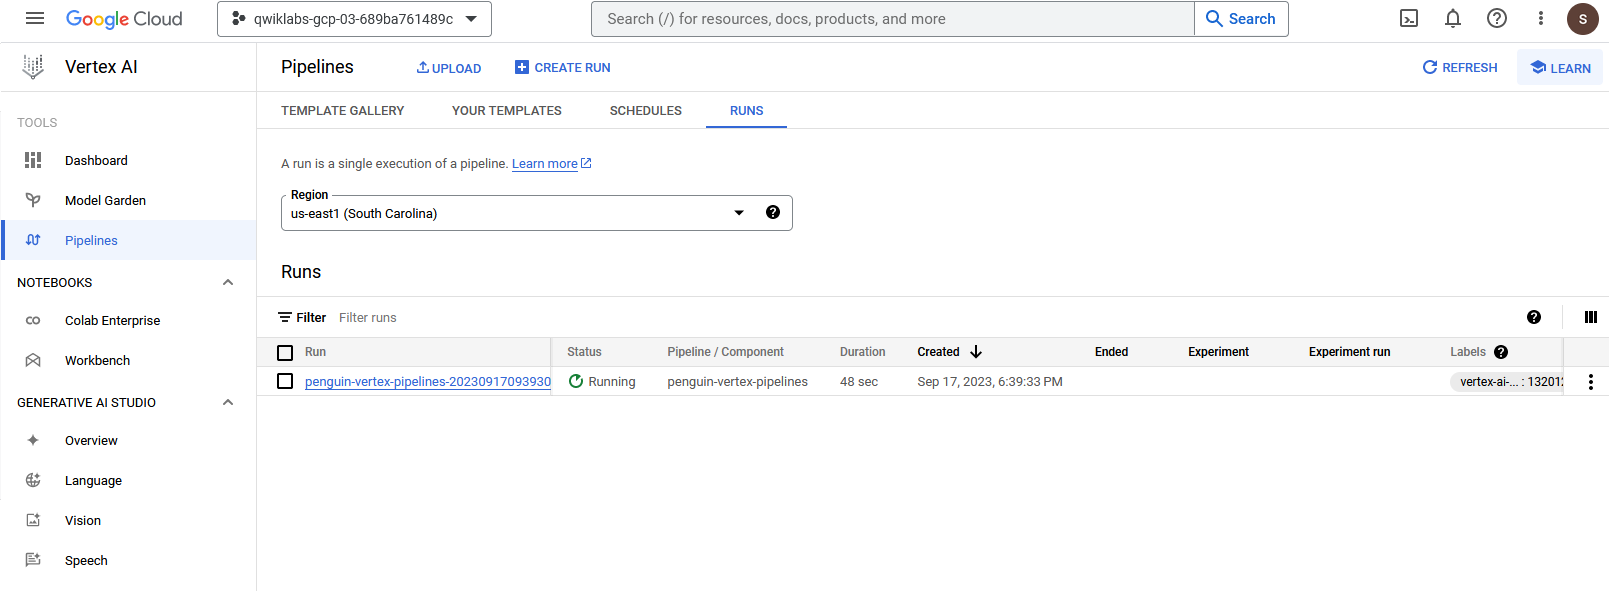

Click on your `penguin-vertex-pipelines-xxx` run:



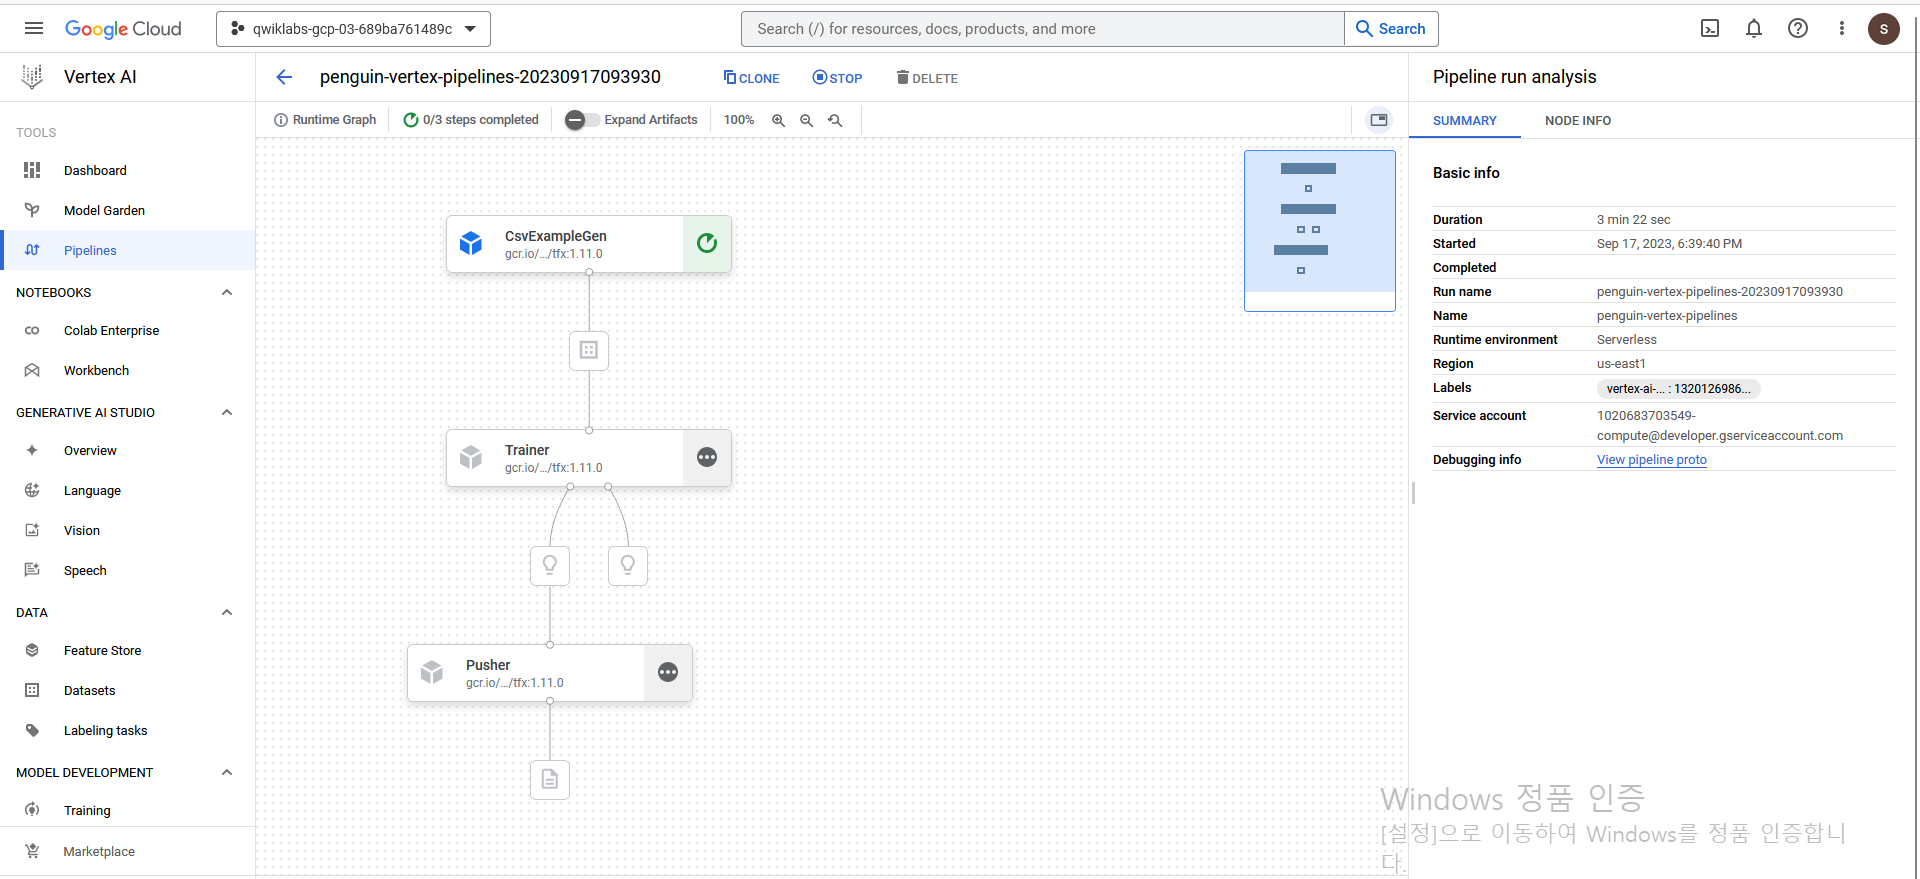

Explore the information displayed in each step while you wait for the job to progress.

On completion, your pipeline UI should look similar to this:

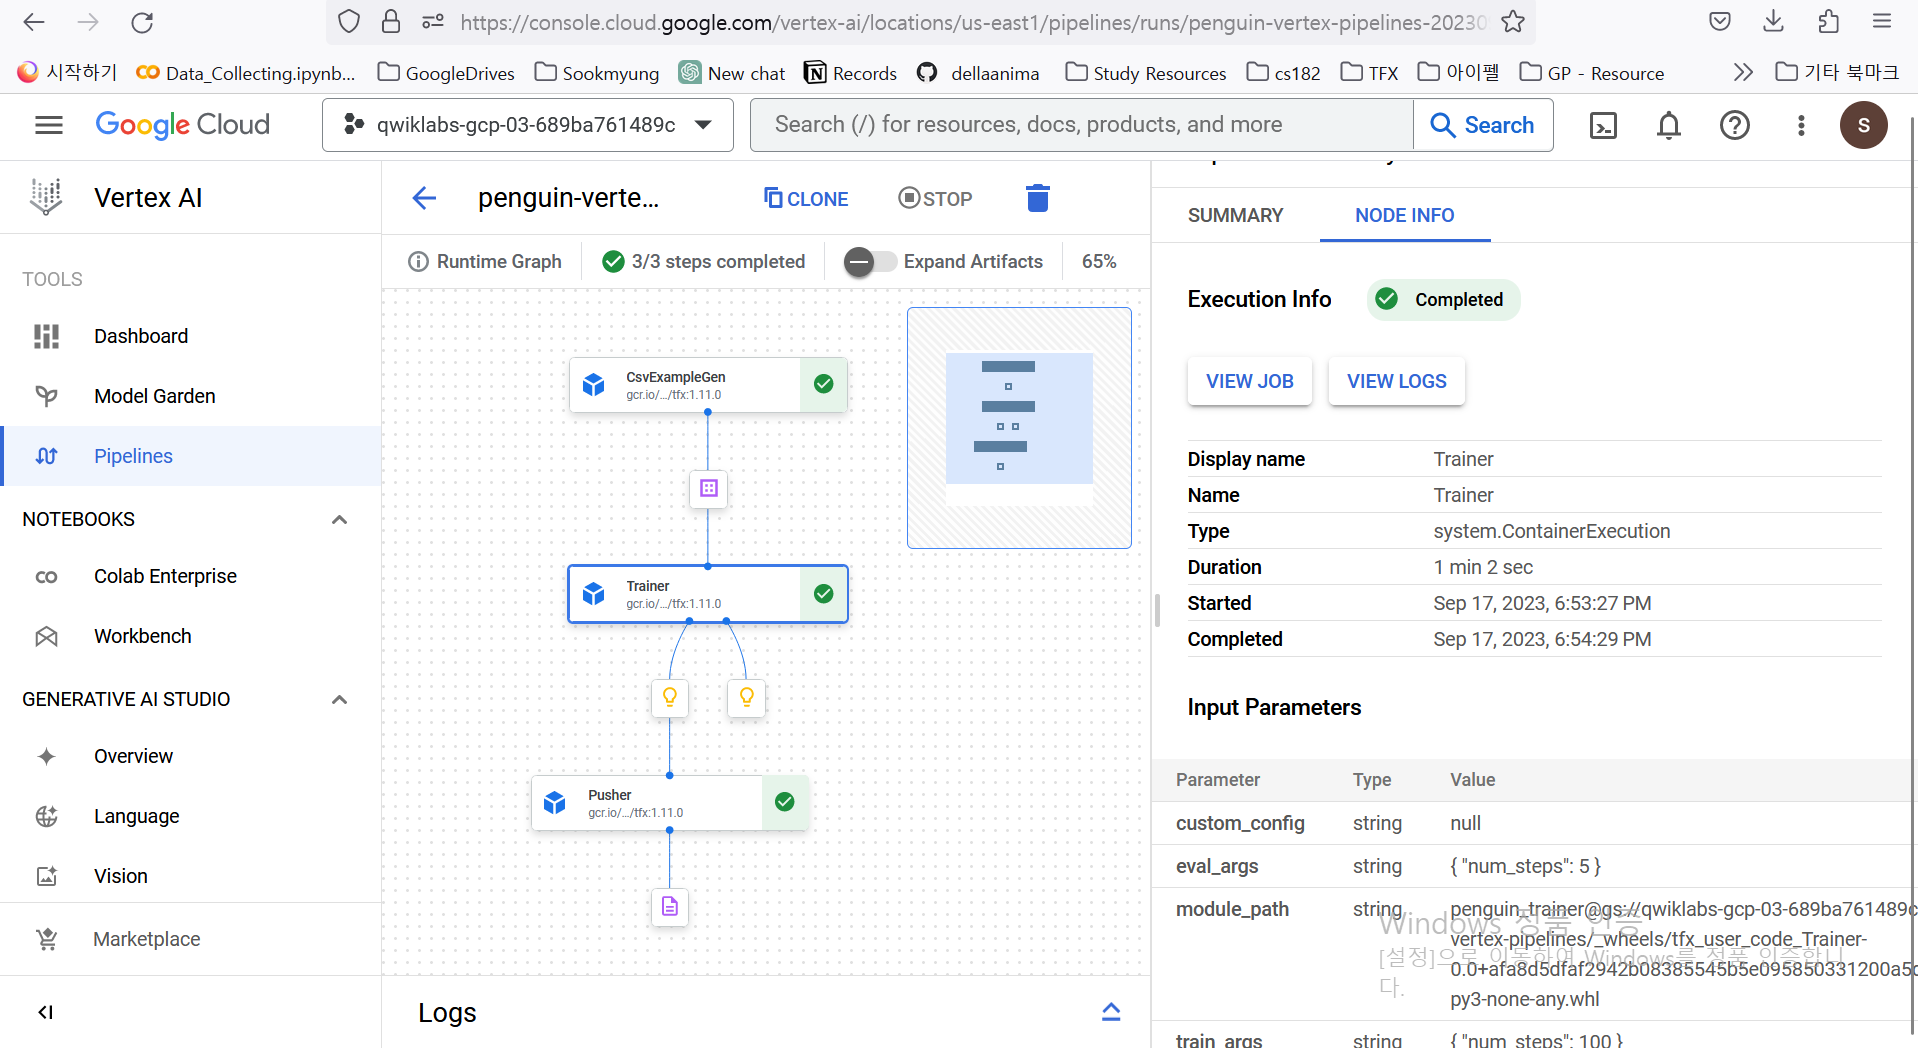

This job will take about 15 minutes in total to complete. Once complete, return to the lab to check your progress.